# Gate Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

In [2]:
# File paths
binary_dir = "Verilog/binary/programs"
ternary_dir = "Verilog/ternary/programs"

In [7]:
# Read in all the binary and ternary csv files while getting the file names

def read_csv_files(directory):

    csv_files = glob.glob(os.path.join(directory, "*_results.csv"))

    # create an empty dataframe to concatenate all the dataframes
    df = pd.DataFrame()

    # Loop through each matching file
    for file_path in csv_files:
        file_name = os.path.basename(file_path) 
        name_part = file_name.split("_results.csv")[0]
        
        # Read the CSV file
        temp_df = pd.read_csv(file_path)

        # Pivot the dataframe to have the 'Gate' column as headers and 'Counts' as values
        temp_df = pd.DataFrame([temp_df.set_index('Gate')['Count'].to_dict()])
        
        # Add a 'name' column with the extracted value
        temp_df['operation'] = name_part
        
        # Append to our list of dataframes
        df = pd.concat([df, temp_df], ignore_index=True)

    return df

binary_df = read_csv_files(binary_dir)
ternary_df = read_csv_files(ternary_dir)

# Add a column to indicate the type of data (binary or ternary)
binary_df['type'] = 'binary'
ternary_df['type'] = 'ternary'

# Combine the two dataframes
gc_df = pd.concat([binary_df, ternary_df], ignore_index=True)

# Replace any NaN values with 0
gc_df = gc_df.fillna(0)

# Convert the 'operation' column to a string type
gc_df['operation'] = gc_df['operation'].astype(str)
# Convert the 'type' column to a string type
gc_df['type'] = gc_df['type'].astype(str)

# Reorder the columns to have 'operation' and 'type' first
gc_df = gc_df[['type', 'operation'] + [col for col in gc_df.columns if col not in ['operation', 'type']]]

# Rename operations to how you want them to be displayed
pass

print(gc_df)

       type       operation   NOT  AND    OR  XOR    ANY
0    binary        addition     0   32    16   32    0.0
1    binary             and     0   16     0    0    0.0
2    binary        equality    16   16     0   16    0.0
3    binary       less_than    32   32    16   16    0.0
4    binary  multiplication   112  560   224  560    0.0
5    binary             not    16    0     0    0    0.0
6    binary              or     0    0    16    0    0.0
7    binary     subtraction    16   32    16   32    0.0
8    binary             xor     0    0     0   16    0.0
9   ternary        addition    90   36    72    0   63.0
10  ternary             and     0    9     0    0    0.0
11  ternary        equality     9   27    18    9    0.0
12  ternary       less_than     9   27    18    9    0.0
13  ternary  multiplication  1323  693  1134   63  882.0
14  ternary             not     9    0     0    0    0.0
15  ternary              or     0    0     9    0    0.0
16  ternary     subtraction    

In [8]:
# Set up the figure and axes with a clean, academic style
plt.rcParams.update({
    'font.family': 'serif',  # Serif fonts are standard in academic papers
    'font.size': 10,         # Base font size
    'axes.labelsize': 11,    # Slightly larger axis labels
    'axes.titlesize': 12,    # Slightly larger title
    'xtick.labelsize': 10,   # Tick label size
    'ytick.labelsize': 10,   # Tick label size
    'legend.fontsize': 10,   # Legend font size
    'figure.dpi': 300        # High resolution for print
})

# Get all gate types and operations
basic_gates = ['NOT', 'AND', 'OR', 'XOR']
all_gates = ['NOT', 'AND', 'OR', 'XOR', 'ANY']
ops = gc_df['operation'].unique()

def plot_gate_usage(gc_df, gate_types, operations, figure_name=None, n_cols=3):
    # We'll create a grid with each operation as a separate subplot
    n_operations = len(operations)
    n_rows = (n_operations + n_cols - 1) // n_cols  # Calculate needed rows

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 3 * n_rows), squeeze=False)

    # Define colors for binary and ternary
    binary_color = '#777777'  # Grey
    ternary_color = '#4477AA'  # Blue

    # Add patterns for grayscale printing
    binary_hatch = ''
    ternary_hatch = '//'

    # Process each operation
    for i, operation in enumerate(operations):
        row_idx = i // n_cols
        col_idx = i % n_cols
        ax = axes[row_idx, col_idx]
        
        operation_data = gc_df[gc_df['operation'] == operation]
        
        # Get binary and ternary data for this operation
        binary_data = operation_data[operation_data['type'] == 'binary']
        ternary_data = operation_data[operation_data['type'] == 'ternary']
        
        # Set up bar positions
        x = np.arange(len(gate_types))
        width = 0.35
        
        # Plot binary data (left bars)
        binary_values = [0] * len(gate_types)
        if not binary_data.empty:
            binary_values = binary_data[gate_types].iloc[0].tolist()
        
        binary_bars = ax.bar(x - width/2, binary_values, width, label='Binary', 
                            color=binary_color, edgecolor='black', linewidth=0.5, hatch=binary_hatch)
        
        # Plot ternary data (right bars)
        ternary_values = [0] * len(gate_types)
        if not ternary_data.empty:
            ternary_values = ternary_data[gate_types].iloc[0].tolist()
        
        ternary_bars = ax.bar(x + width/2, ternary_values, width, label='Ternary', 
                            color=ternary_color, edgecolor='black', linewidth=0.5, hatch=ternary_hatch)
        
        # Add value labels on bars
        for j, v in enumerate(binary_values):
            if v > 0:  # Only label non-zero values
                ax.text(j - width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)
        
        for j, v in enumerate(ternary_values):
            if v > 0:  # Only label non-zero values
                ax.text(j + width/2, v + 0.5, str(v), ha='center', va='bottom', fontsize=8)
        
        # Set y scale to log if we have very large values compared to small ones
        all_values = binary_values + ternary_values
        non_zero_values = [v for v in all_values if v > 0]
        
        if non_zero_values:
            max_val = max(non_zero_values)
            min_val = min(non_zero_values)
            
            if max_val / min_val > 50:  # If largest value is >50x the smallest non-zero value
                # Use log scale
                ax.set_yscale('log')
        
        # Configure axes
        ax.set_title(f'{operation.capitalize()}', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(gate_types, rotation=45, ha='right')
        
        # Add gridlines
        ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
        ax.set_axisbelow(True)  # Place gridlines behind data
        
        # Customize spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add legend only for the first subplot
        if i == 0:
            ax.legend(frameon=True, framealpha=1, edgecolor='black', fancybox=False)

    # Hide empty subplots if any
    for i in range(n_operations, n_rows * n_cols):
        row_idx = i // n_cols
        col_idx = i % n_cols
        axes[row_idx, col_idx].set_visible(False)

    # Add main title
    # plt.suptitle('Gate Usage by Operation: Binary vs Ternary', fontweight='bold', fontsize=14)

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # Adjust layout with space for the title
    plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Add space between subplots

    # Add a subtle border around the figure
    fig.patch.set_linewidth(1)
    fig.patch.set_edgecolor('black')

    # Uncomment to save
    if figure_name:
        plt.savefig(f'Diss/figures/{figure_name}.png', dpi=300, bbox_inches='tight')  # PNG for preview
        plt.close()  # Close the figure to free up memory
    else:
        plt.show()

In [11]:
basic_operations = ['not', 'and', 'or', 'xor']
complex_operations = list(set(ops) - set(basic_operations))

plot_gate_usage(gc_df, basic_gates, basic_operations, n_cols=2, figure_name='trivial_gate_usage')
plot_gate_usage(gc_df, all_gates, complex_operations, n_cols=2, figure_name='complex_gate_usage')
# plot_gate_usage(gc_df, basic_gates, basic_operations, n_cols=2)
# plot_gate_usage(gc_df, all_gates, complex_operations, n_cols=2)

## Number of Transistors per Gate

In [12]:
gate_transistors = {
    'CMOS' : {
        'NOT': 2,
        'AND': 6,
        'NAND': 4,
        'OR': 6,
        'NOR': 4,
        'XOR': 12,
    },
    'CNFET' : {
        'NTI': 5,
        'NOT': 5,
        'PTI': 5,
        'AND': 15,
        'NAND': 10,
        'OR': 15,
        'NOR': 10,
        'XOR': 18,
        'ANY': 7,
        'CONS': 55,
    }
}

# create a new dataframe from the gate_transistors dictionary
technology_list = []
gate_list = []
count_list = []

# Populate the lists from the dictionary
for technology, gates in gate_transistors.items():
    for gate, count in gates.items():
        technology_list.append(technology)
        gate_list.append(gate)
        count_list.append(count)

# Create the DataFrame
tc_df = pd.DataFrame({
    'Technology': technology_list,
    'Gate': gate_list,
    'Count': count_list
})

# add a column called Technology to the gc_df dataframe 
# with the same values as the Technology column in the tc_df dataframe
gc_df['Technology'] = gc_df['type'].map(lambda x: 'CMOS' if x == 'binary' else 'CNFET')

# Add a new column to the gc_df dataframe called 'Transistor Count' on the next line
gc_df['Transistor Count'] = 0

# For each row in gc_df, add a transistor count column which is the sum of the transistor counts for each gate in the row
for index, row in gc_df.iterrows():
    
    operation = row['Technology']
    transistor_count = row['NOT'] * tc_df[(tc_df['Technology'] == operation) & (tc_df['Gate'] == 'NOT')]['Count'].values[0]
    transistor_count += row['AND'] * tc_df[(tc_df['Technology'] == operation) & (tc_df['Gate'] == 'AND')]['Count'].values[0]
    transistor_count += row['OR'] * tc_df[(tc_df['Technology'] == operation) & (tc_df['Gate'] == 'OR')]['Count'].values[0]
    transistor_count += row['XOR'] * tc_df[(tc_df['Technology'] == operation) & (tc_df['Gate'] == 'XOR')]['Count'].values[0]

    # Add the transistor count to the gc_df dataframe
    gc_df.at[index, 'Transistor Count'] = transistor_count

gc_df

,type,operation,NOT,AND,OR,XOR,ANY,Technology,Transistor Count
0,binary,addition,0,32,16,32,0.0,CMOS,672
1,binary,and,0,16,0,0,0.0,CMOS,96
2,binary,equality,16,16,0,16,0.0,CMOS,320
3,binary,less_than,32,32,16,16,0.0,CMOS,544
4,binary,multiplication,112,560,224,560,0.0,CMOS,11648
5,binary,not,16,0,0,0,0.0,CMOS,32
6,binary,or,0,0,16,0,0.0,CMOS,96
7,binary,subtraction,16,32,16,32,0.0,CMOS,704
8,binary,xor,0,0,0,16,0.0,CMOS,192
9,ternary,addition,90,36,72,0,63.0,CNFET,2070


## Visualise Gate Counts for each Operation

In [13]:
def plot_transistor_comparison(gc_df, operations, figure_name=None):

    # Get unique operations
    technologies = gc_df['Technology'].unique().tolist()
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define bar properties
    bar_width = 0.35
    opacity = 1.0
    
    # Define colors for different technologies
    cmos_color = '#777777'  # Grey
    cnfet_color = '#4477AA'  # Blue
    
    # Add patterns for grayscale printing
    cmos_hatch = ''
    cnfet_hatch = '//'
    
    # Set up bar positions
    x = np.arange(len(operations))
    
    # Initialize bars for legend
    cmos_bars = None
    cnfet_bars = None
    
    # Plot bars for each technology
    for i, tech in enumerate(technologies):
        tech_data = gc_df[gc_df['Technology'] == tech]
        
        # Prepare data for each operation
        transistor_counts = []
        for op in operations:
            op_data = tech_data[tech_data['operation'] == op]
            if not op_data.empty:
                transistor_counts.append(op_data['Transistor Count'].values[0])
            else:
                transistor_counts.append(0)
        
        # Determine position offset based on technology
        position = x - bar_width/2 if tech == 'CMOS' else x + bar_width/2
        color = cmos_color if tech == 'CMOS' else cnfet_color
        hatch = cmos_hatch if tech == 'CMOS' else cnfet_hatch
        
        # Create bars
        bars = ax.bar(position, transistor_counts, bar_width,
                      alpha=opacity, color=color, 
                      edgecolor='black', linewidth=0.5,
                      hatch=hatch, label=tech)
        
        # Store bars for legend
        if tech == 'CMOS':
            cmos_bars = bars
        else:
            cnfet_bars = bars
        
        # Add value labels on bars
        for j, count in enumerate(transistor_counts):
            offset = -bar_width/2 if tech == 'CMOS' else bar_width/2
            ax.text(x[j] + offset, count + 2, str(count), 
                   ha='center', va='bottom', fontsize=10)
    
    # Configure axes
    ax.set_xlabel('Operation', fontweight='bold')
    ax.set_ylabel('Transistor Count', fontweight='bold')
    # ax.set_title('Transistor Count Comparison by Operation and Technology', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([op.capitalize() for op in operations])
    
    # Add gridlines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
    ax.set_axisbelow(True)  # Place gridlines behind data
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(frameon=True, framealpha=1, edgecolor='black', fancybox=False)
    
    plt.tight_layout()
    
    # Add a subtle border around the figure
    fig.patch.set_linewidth(1)
    fig.patch.set_edgecolor('black')
    
    # Save or show the figure
    if figure_name:
        plt.savefig(f'Diss/figures/{figure_name}.png', dpi=300, bbox_inches='tight')
        plt.close()  # Close the figure to free up memory
    else:
        plt.show()

    return fig

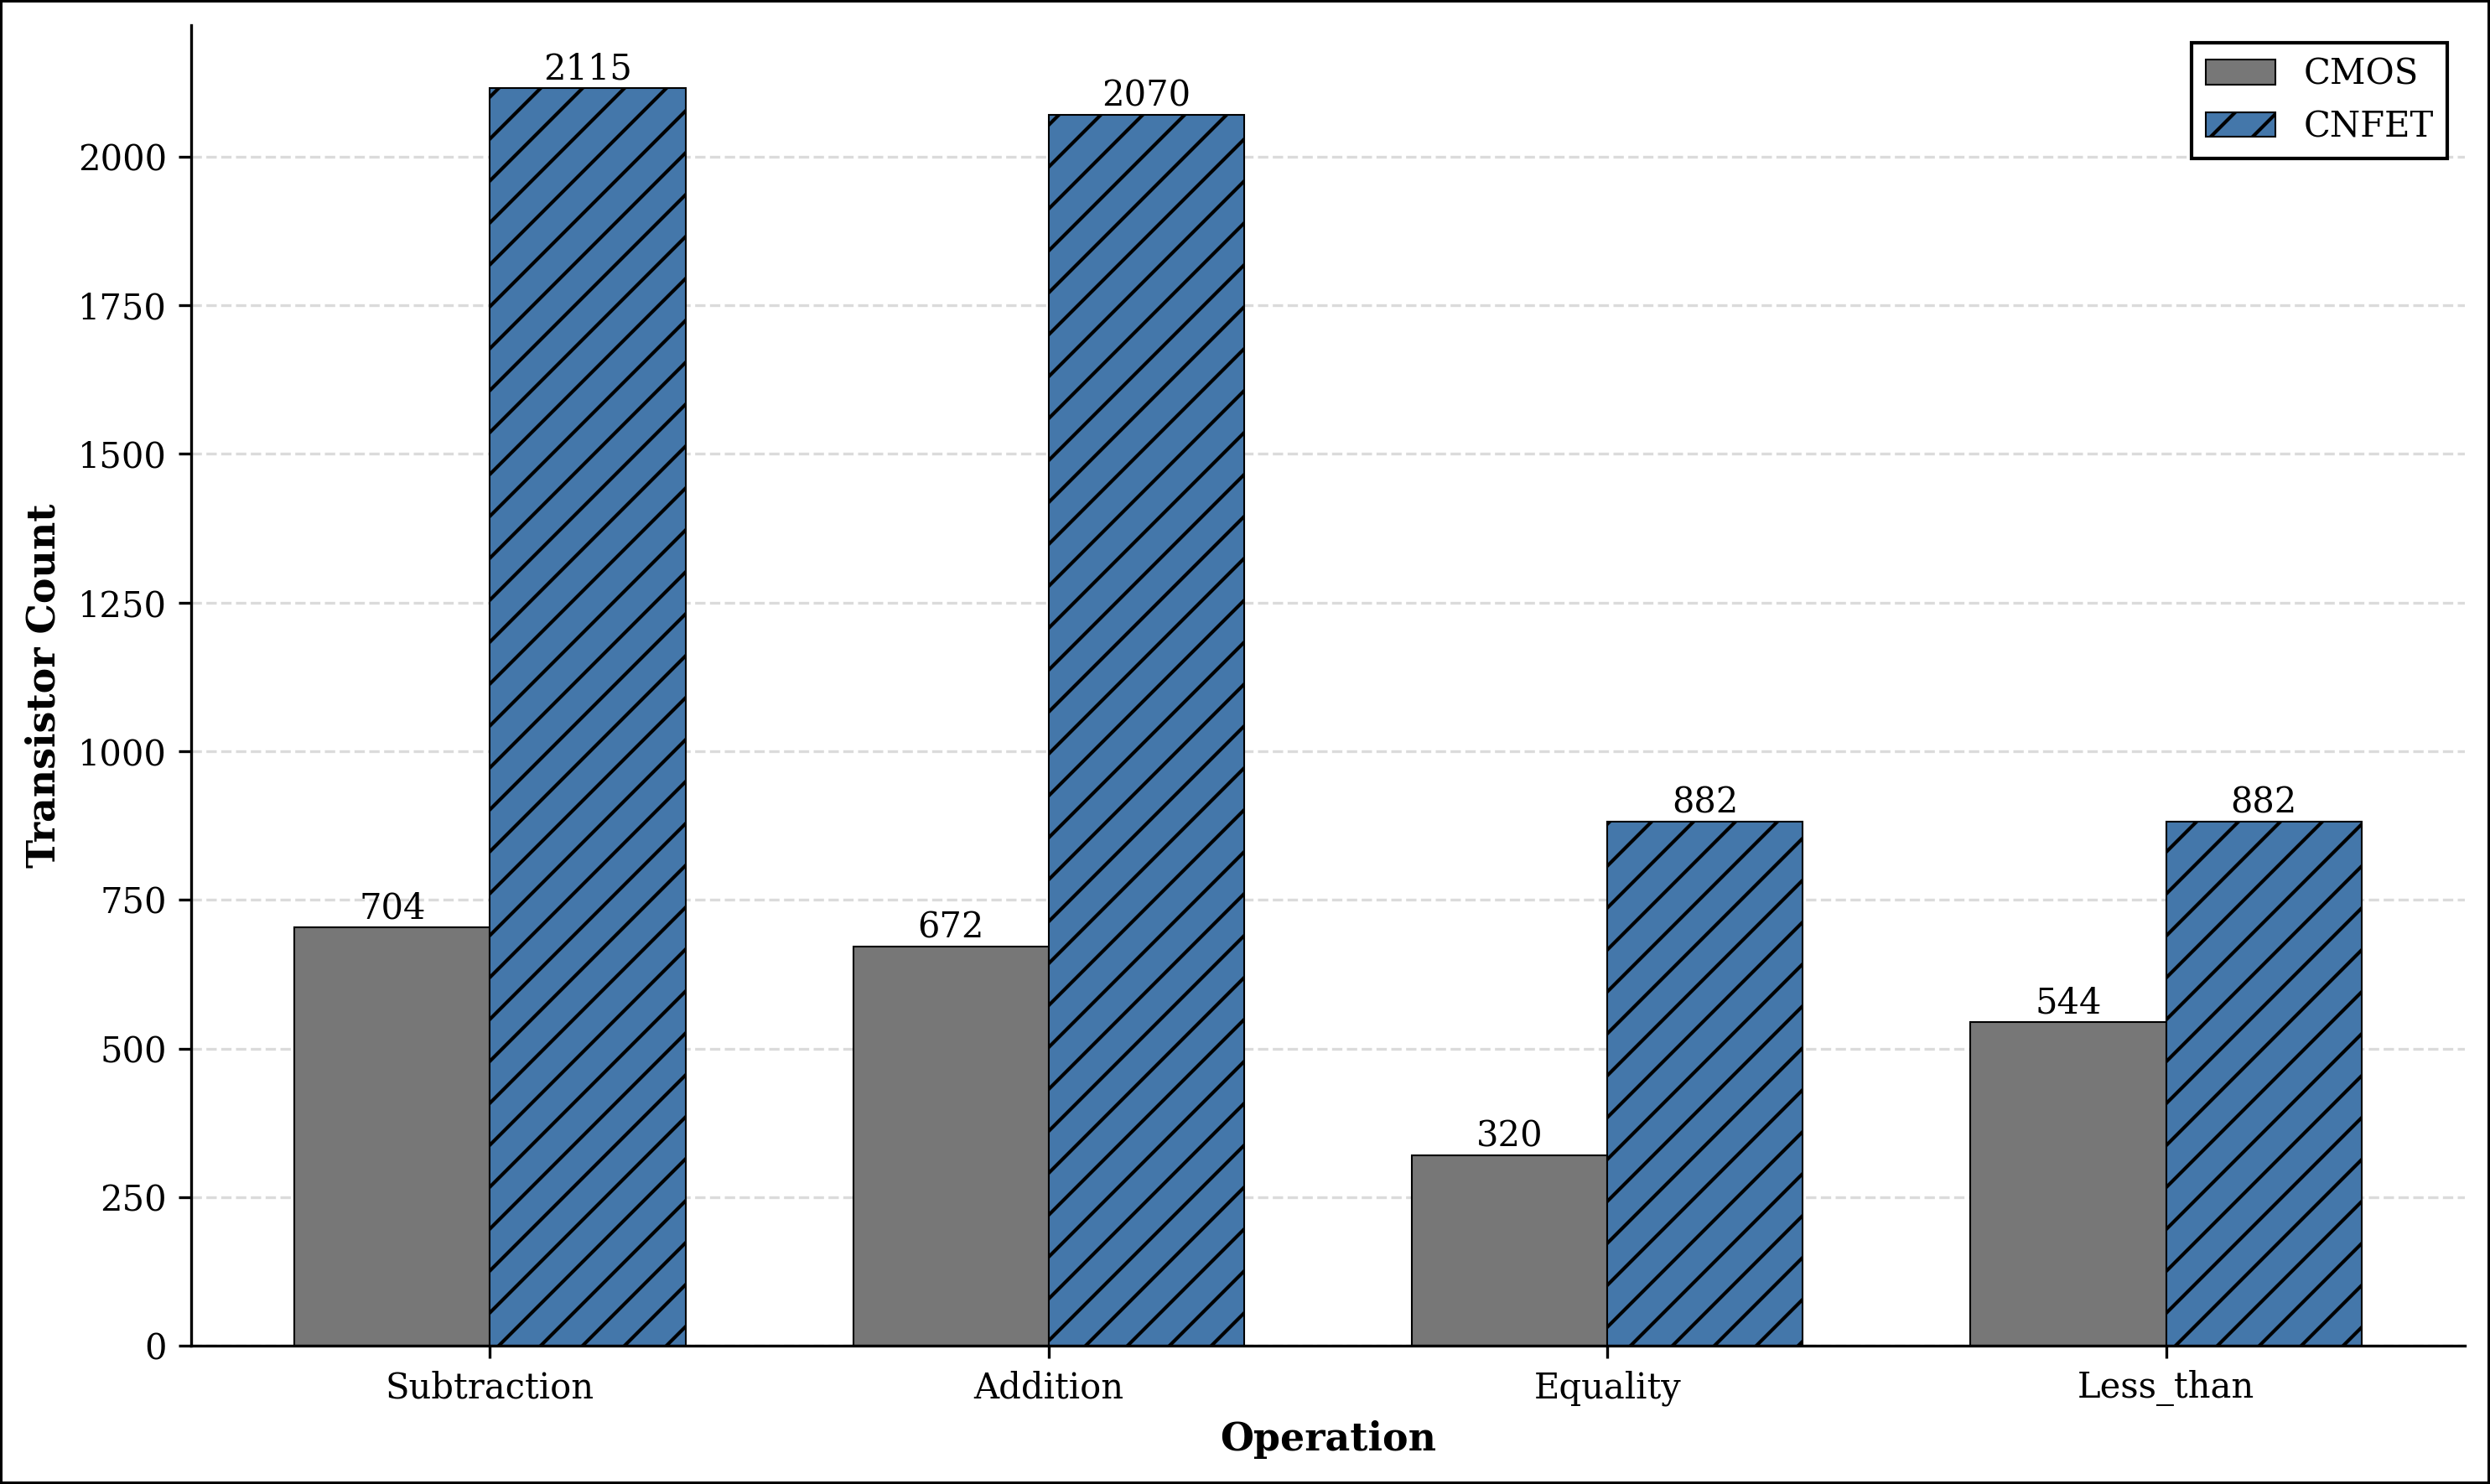

In [22]:
basic_operations = ['not', 'and', 'or', 'xor']
complex_operations = list(set(ops) - set(basic_operations))
complex_operations.remove('multiplication')

# fig = plot_transistor_comparison(gc_df, basic_operations)
plot_transistor_comparison(gc_df, basic_operations, figure_name='basic_transistor_count')
plot_transistor_comparison(gc_df, complex_operations, figure_name='complex_transistor_count')

## Circuit Propagation Delay

In [ ]:
circuit_propagation_delay = {
    'CMOS' : {
        'NOT': 1,
        'AND': 2,
        'NAND': 2,
        'OR': 2,
        'NOR': 2,
        'XOR': 3,
        'Half Adder': 3, # 1x XOR
        'Full Adder': 8, # 2x Half Adder, 1x OR
    },
    'CNFET' : {
        'NOT': 2,
        'NTI': 2,
        'PTI': 2,
        'AND': 5,
        'NAND': 3,
        'OR': 5,
        'NOR': 3,
        'XOR': 4, 
        'CONS': 12, # 1x PTI, 2x AND
        'ANY': 6,
        'Addition': 18, # 3x ANY
        'Half Adder': 18, # 1x Addition
        'Full Adder': 42, # 2x Half Adder, 1x ANY
    }
}

cpd = circuit_propagation_delay

BIN_WIDTH = 16
TER_WIDTH = 9

print(BIN_WIDTH * cpd['CMOS']['Full Adder'])

operation_delay = {
    'binary': {
        'not': 1,
        'and': 2,
        'or': 2,
        'xor': 3,
        'addition': int(BIN_WIDTH * cpd['CMOS']['Full Adder']),
        'subtraction': int(1 + BIN_WIDTH * cpd['CMOS']['Full Adder']),
    },
    'ternary': {
        'not': 2,
        'and': 5,
        'or': 5,
        'xor': 4,
        'addition': int(TER_WIDTH * cpd['CNFET']['Full Adder']),
        'subtraction': int(1 + TER_WIDTH * cpd['CNFET']['Full Adder']),
    }
}

128


In [31]:
def plot_propagation_delay(op_delay, operations, figure_name=None):

    # Import required libraries
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Get unique number systems
    number_systems = list(op_delay.keys())  # binary and ternary
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Define bar properties
    bar_width = 0.35
    opacity = 1.0
    
    # Define colors for different number systems
    binary_color = '#777777'  # Grey
    ternary_color = '#4477AA'  # Blue
    
    # Add patterns for grayscale printing
    binary_hatch = ''
    ternary_hatch = '//'
    
    # Set up bar positions
    x = np.arange(len(operations))
    
    # Initialize bars for legend
    binary_bars = None
    ternary_bars = None
    
    # Plot bars for each number system
    for i, system in enumerate(number_systems):
        system_data = op_delay[system]
        
        # Prepare data for each operation
        delay_values = []
        for op in operations:
            if op in system_data:
                delay_values.append(system_data[op])
            else:
                delay_values.append(0)
        
        # Determine position offset based on number system
        position = x - bar_width/2 if system == 'binary' else x + bar_width/2
        color = binary_color if system == 'binary' else ternary_color
        hatch = binary_hatch if system == 'binary' else ternary_hatch
        
        # Create bars
        bars = ax.bar(position, delay_values, bar_width,
                      alpha=opacity, color=color, 
                      edgecolor='black', linewidth=0.5,
                      hatch=hatch, label=system.capitalize())
        
        # Store bars for legend
        if system == 'binary':
            binary_bars = bars
        else:
            ternary_bars = bars
        
        # Add value labels on bars
        for j, value in enumerate(delay_values):
            offset = -bar_width/2 if system == 'binary' else bar_width/2
            ax.text(x[j] + offset, value + (max(delay_values) * 0.02), f"{value:.1f}", 
                   ha='center', va='bottom', fontsize=10)
    
    # Configure axes
    ax.set_xlabel('Operation', fontweight='bold')
    ax.set_ylabel('Propagation Delay Units', fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([op.capitalize() for op in operations])
    
    # Add gridlines
    ax.yaxis.grid(True, linestyle='--', alpha=0.7, color='#cccccc')
    ax.set_axisbelow(True)  # Place gridlines behind data
    
    # Customize spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Add legend
    ax.legend(frameon=True, framealpha=1, edgecolor='black', fancybox=False)
    
    plt.tight_layout()
    
    # Add a subtle border around the figure
    fig.patch.set_linewidth(1)
    fig.patch.set_edgecolor('black')
    
    # Save or show the figure
    if figure_name:
        plt.savefig(f'Diss/figures/{figure_name}.png', dpi=300, bbox_inches='tight')
        plt.close()  # Close the figure to free up memory
    else:
        plt.show()

    return fig

['addition', 'and', 'not', 'or', 'subtraction', 'xor']


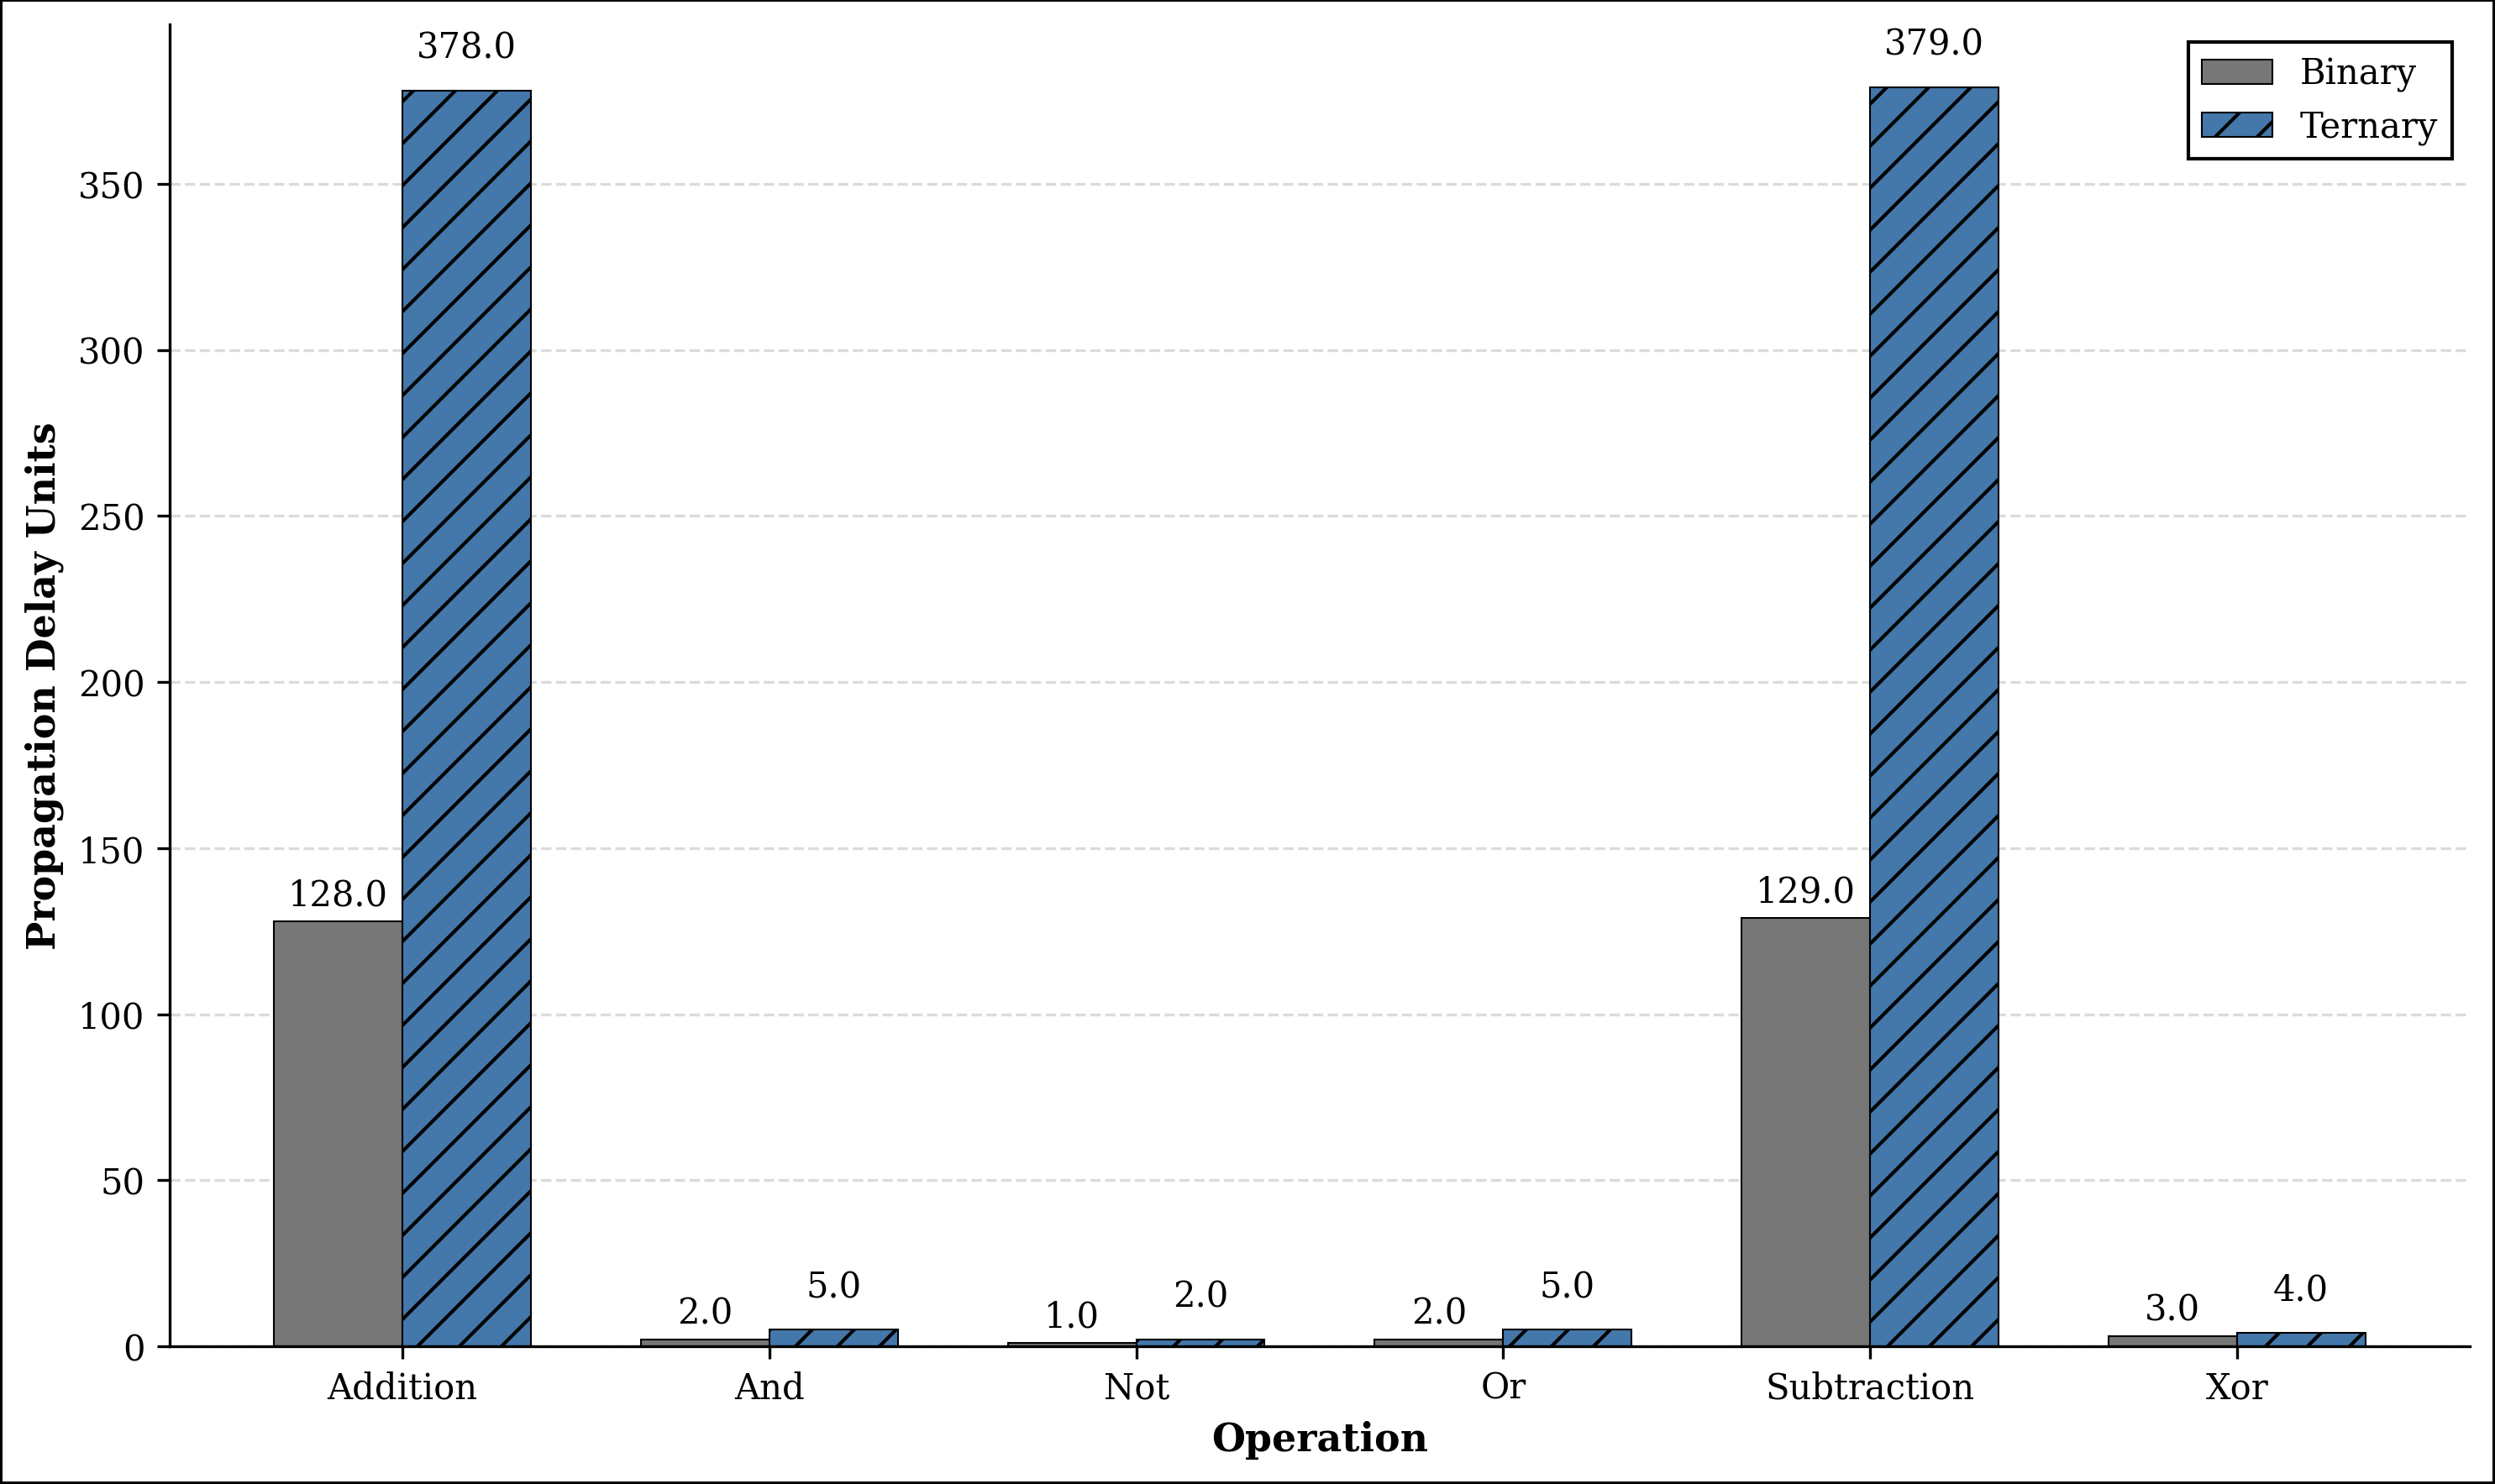

In [37]:
operations = list(ops).copy()
operations.remove('multiplication')
operations.remove('less_than')
operations.remove('equality')

print(operations)

plot_propagation_delay(operation_delay, operations, figure_name='prop_delays')
# plot_propagation_delay(operation_delay, complex_operations, figure_name='prop_delay_complex')

## CNFET vs. CMOS Propagation Delay

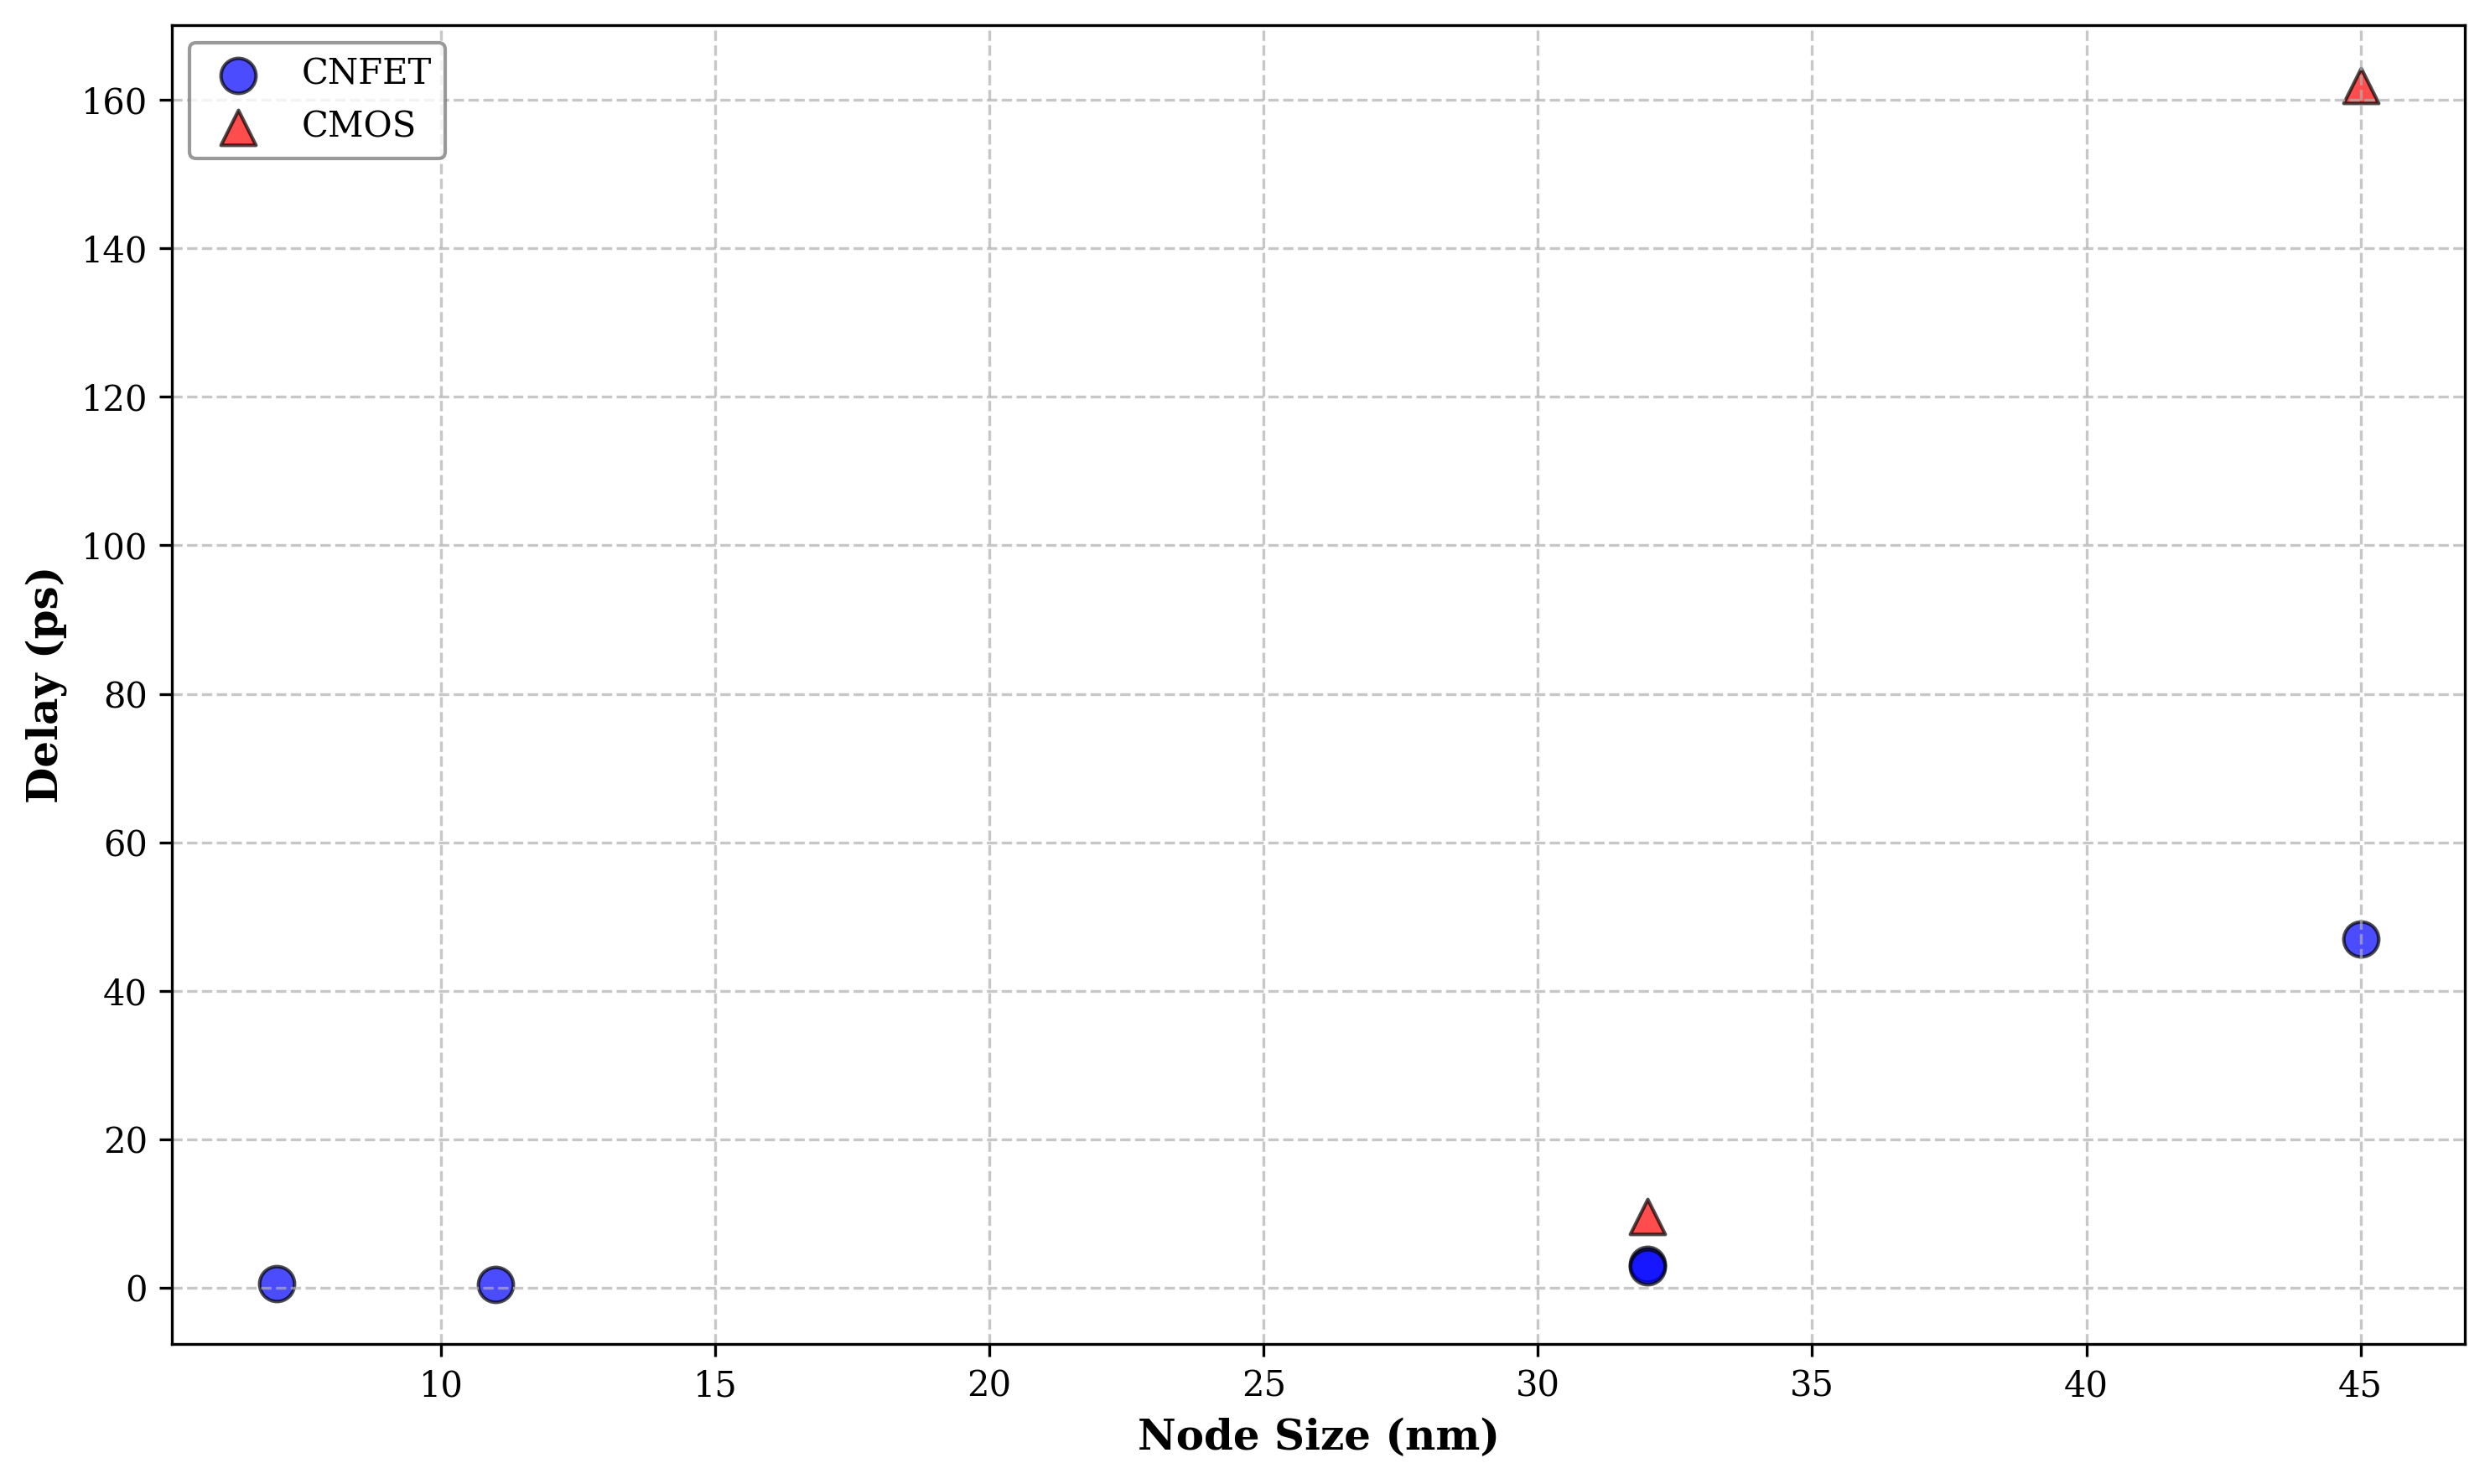

In [8]:
# Data from the table
gates = ['CNFET', 'CNFET', 'CNFET', 'CMOS', 'CNFET', 'CNFET', 'CMOS']
node_sizes = [11, 7, 45, 45, 32, 32, 32]
delays = [0.48, 0.55, 47, 162, 3.11, 2.79, 9.55]

# gates = ['CNFET', 'CNFET', 'CNFET', 'CNFET', 'CMOS']
# node_sizes = [11, 7, 32, 32, 32]
# delays = [0.48, 0.55, 3.11, 2.79, 9.55]

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Separate CNFET and CMOS data
cnfet_sizes = [size for size, gate in zip(node_sizes, gates) if gate == 'CNFET']
cnfet_delays = [delay for delay, gate in zip(delays, gates) if gate == 'CNFET']
cmos_sizes = [size for size, gate in zip(node_sizes, gates) if gate == 'CMOS']
cmos_delays = [delay for delay, gate in zip(delays, gates) if gate == 'CMOS']

# Plot CNFET data
plt.scatter(cnfet_sizes, cnfet_delays, color='blue', marker='o', label='CNFET', 
            edgecolors='black', linewidth=1, alpha=0.7, s=100)

# Plot CMOS data
plt.scatter(cmos_sizes, cmos_delays, color='red', marker='^', label='CMOS', 
            edgecolors='black', linewidth=1, alpha=0.7, s=100)

# Customize the plot
plt.xlabel('Node Size (nm)', fontsize=12, fontweight='bold')
plt.ylabel('Delay (ps)', fontsize=12, fontweight='bold')
# plt.title('Comparison of CNFET and CMOS - Node Size vs Delay', 
        #   fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(frameon=True, framealpha=0.8, edgecolor='gray')

# Add a tight layout and show the plot
plt.tight_layout()
plt.savefig('Diss/figures/cnfet_cmos_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

## LUI Instruction Visualisation

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern Roman
findfont: Generic family 'serif' not found because none of the following

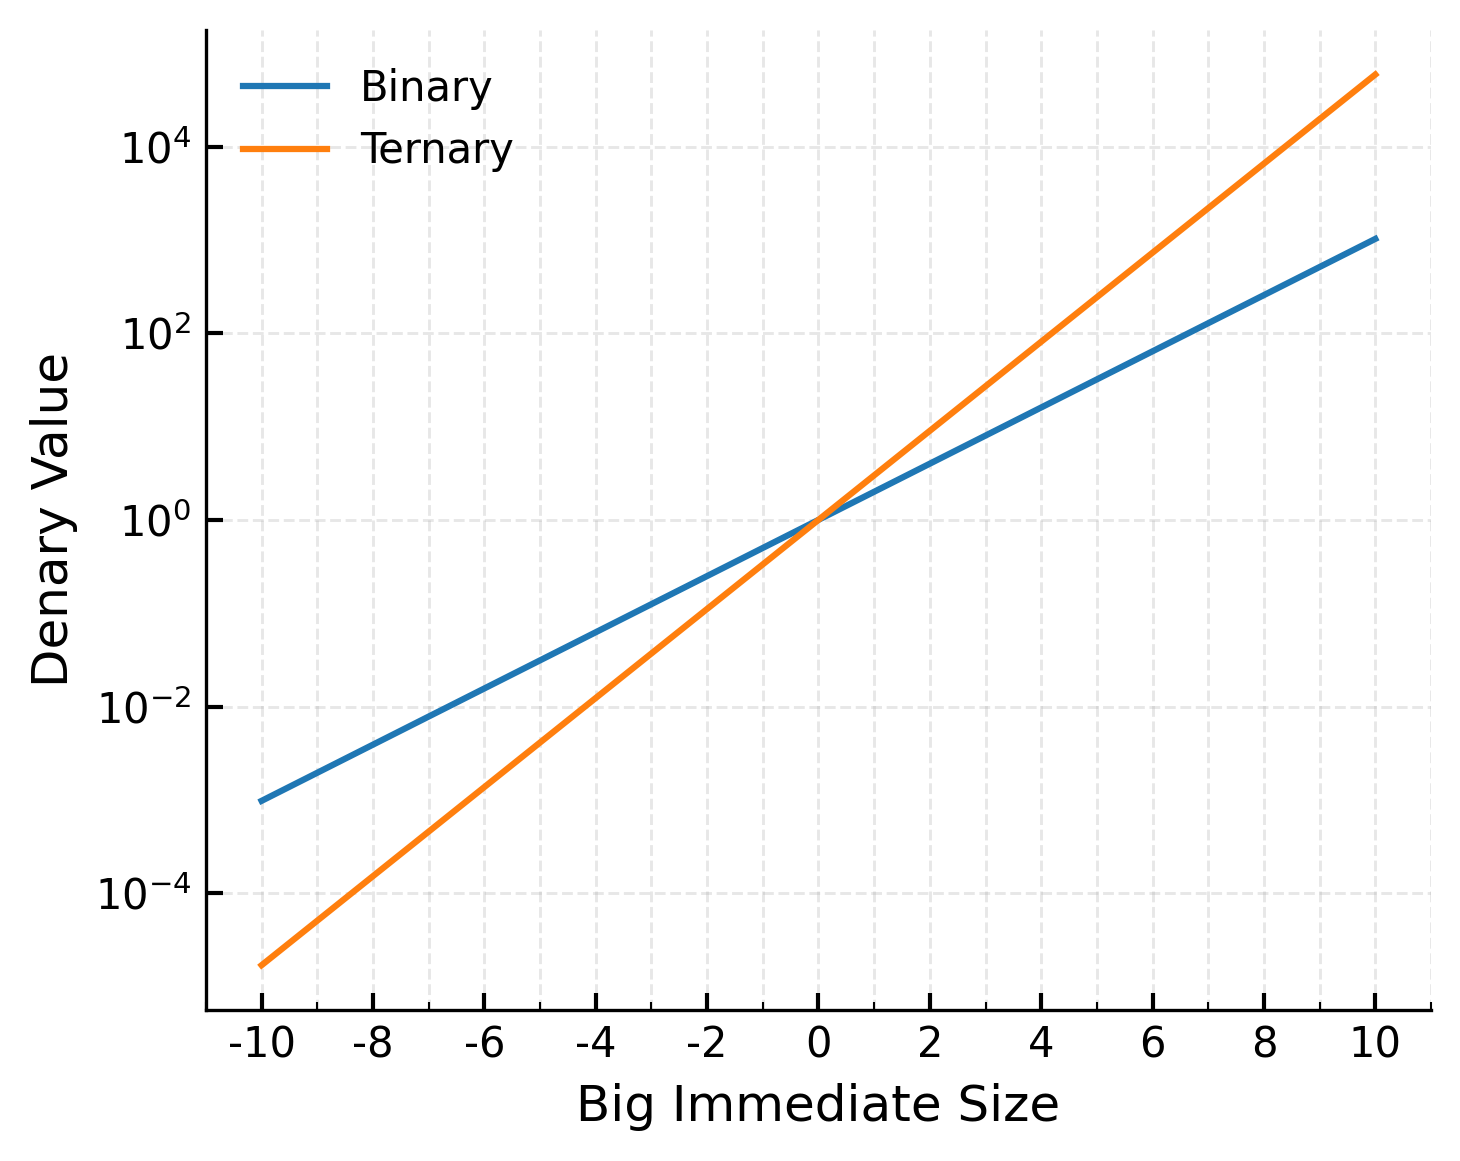

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl
import matplotlib.ticker as ticker

# Set up the matplotlib parameters for academic style WITHOUT LaTeX
plt.rcParams.update({
    'font.size': 11,
    'text.usetex': False,  # Disable LaTeX rendering
    'mathtext.default': 'regular',  # Still use math formatting
    'axes.labelsize': 12,
    'axes.titlesize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 10,
    'figure.figsize': (5, 4),
    'figure.dpi': 300,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'lines.linewidth': 1.5,
    'axes.axisbelow': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
})

# Create x values
x = np.linspace(-10, 10, 1000)

# Calculate y values
y1 = 2**x
y2 = 3**x

# Create the figure and axis
fig, ax = plt.subplots()

# Plot the functions
ax.semilogy(x, y1, label='Binary', color='#1f77b4')
ax.semilogy(x, y2, label='Ternary', color='#ff7f0e')

# Adjust grid
ax.grid(True, which="both", linestyle='--', linewidth=0.7)

# Set integer ticks on x-axis
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))  # Major ticks every 2 units
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))  # Minor ticks every 1 unit
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))  # Format as integers

# Add labels and title
ax.set_xlabel('Big Immediate Size')
ax.set_ylabel('Denary Value')

# Adjust tick marks
ax.tick_params(direction='in', length=4, width=1)
ax.tick_params(which='minor', direction='in', length=2, width=0.5)

# Add legend
ax.legend(frameon=False)

# Adjust layout
plt.tight_layout()

plt.savefig('Diss/figures/exponential_functions.png', bbox_inches='tight', dpi=300)
plt.show()